## Regressão simbólica aplicada ao modelo populacional de Malthuls 

In [1]:
from deap import base, creator, tools, gp
from deap.algorithms import eaSimple
import math
import numpy
import operator
import random as rd
import lmfit
import numpy as np
import sympy as sp
import matplotlib.pyplot as plt
plt.style.use('seaborn-bright')
from sympy import Symbol, expand
from funcoes import malthus, runge_kutta
from funcoes import Div, Exp

### Solução numérica para o modelo dada pelo método de Runge-Kutta

In [2]:
T0 = 0
TF = 1
H = 0.01
X0 = 3
K = 1

T, X = runge_kutta(malthus, T0, X0, TF, H, K)

In [3]:
NUM_GERACOES = 500
TAMANHO_POP = 1000
TAMANHO_TORNEIO = 3
CHANCE_CRUZAMENTO = 0.5
CHANCE_MUTACAO = 0.03

In [4]:
pset = gp.PrimitiveSet("MAIN", 1)
pset.addPrimitive(operator.add, 2)
pset.addPrimitive(operator.sub, 2)
pset.addPrimitive(operator.mul, 2)
pset.addPrimitive(Div, 2)
pset.addPrimitive(operator.neg, 1)
#pset.addPrimitive(np.cos, 1)
#pset.addPrimitive(np.sin, 1)
pset.addPrimitive(Exp, 1)


pset.addEphemeralConstant("rand101", lambda: rd.randint(-1,1))

pset.renameArguments(ARG0='t')

In [5]:
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", gp.PrimitiveTree, fitness=creator.FitnessMin)

In [6]:
toolbox = base.Toolbox()
toolbox.register("expr", gp.genHalfAndHalf, pset=pset, min_=1, max_=2)
toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.expr)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("compile", gp.compile, pset=pset)

In [7]:
def fitness(individual, points):
    # solução numérica:
    # Transformar a expressão em função:
    func = toolbox.compile(expr=individual)
    Xexpr = func(T)
    RMSE = np.sqrt(sum((Xexpr - X)**2))
    tamanho = len(str(individual))
    if tamanho > 50:
        return float('inf'),
    else:
        return (RMSE**1) * (1+tamanho/5)**0,

In [8]:
toolbox.register("evaluate", fitness, points = list(np.arange(T0, TF + H, H)))
toolbox.register("select", tools.selTournament, tournsize=TAMANHO_TORNEIO)
toolbox.register("mate", gp.cxOnePoint)
toolbox.register("expr_mut", gp.genFull, min_=0, max_=2)
toolbox.register("mutate", gp.mutUniform, expr=toolbox.expr_mut, pset=pset)
toolbox.decorate("mate", gp.staticLimit(key=operator.attrgetter("height"), max_value=17))
toolbox.decorate("mutate", gp.staticLimit(key=operator.attrgetter("height"), max_value=17))

In [9]:
stats_fit = tools.Statistics(lambda ind: ind.fitness.values)
stats_size = tools.Statistics(len)
mstats = tools.MultiStatistics(fitness=stats_fit, size=stats_size)
mstats.register("avg", numpy.mean)
mstats.register("std", numpy.std)
mstats.register("min", numpy.min)

In [10]:
pop = toolbox.population(n=TAMANHO_POP)
hof = tools.HallOfFame(5)
pop, log = eaSimple(pop, toolbox,
                cxpb=CHANCE_CRUZAMENTO,mutpb=CHANCE_MUTACAO, 
                ngen=NUM_GERACOES , stats=mstats, halloffame=hof, verbose=True)

   	      	                      fitness                      	                  size                 
   	      	---------------------------------------------------	---------------------------------------
gen	nevals	avg        	gen	min    	nevals	std        	avg  	gen	min	nevals	std    
0  	1000  	8.06435e+40	0  	5.06825	1000  	1.47013e+42	3.927	0  	2  	1000  	1.66183
1  	543   	54.9638    	1  	5.06825	543   	331.192    	3.829	1  	1  	543   	1.69757
2  	511   	37.8625    	2  	5.06825	511   	14.1741    	3.728	2  	1  	511   	1.74815
3  	541   	1.26833e+41	3  	5.06825	541   	2.60162e+42	3.767	3  	1  	541   	1.76202
4  	509   	inf        	4  	1.55263	509   	nan        	4.154	4  	1  	509   	1.84182
5  	542   	1.48352e+41	5  	1.55263	542   	3.31397e+42	4.612	5  	1  	542   	1.93222


C:\JupyterLab\meu-jupyter-ilum\3 semestre\Redes Neurais\RNAG_Trabalho_Final\funcoes.py:92: RuntimeWarning: overflow encountered in exp
  result = np.exp(x)
C:\Users\MARCOS~1\AppData\Local\Temp/ipykernel_18404/1863226702.py:6: RuntimeWarning: overflow encountered in square
  RMSE = np.sqrt(sum((Xexpr - X)**2))
c:\venv\ilumpy\lib\site-packages\numpy\core\_methods.py:202: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


6  	530   	1.4761e+41 	6  	1.55263	530   	3.29736e+42	4.859	6  	1  	530   	1.91602
7  	520   	inf        	7  	1.55263	520   	nan        	5.018	7  	1  	520   	2.04882
8  	522   	inf        	8  	1.55263	522   	nan        	4.868	8  	1  	522   	2.14116
9  	515   	inf        	9  	1.55263	515   	nan        	4.894	9  	1  	515   	2.30451
10 	552   	inf        	10 	1.55263	552   	nan        	5.126	10 	1  	552   	2.58653
11 	511   	inf        	11 	1.55263	511   	nan        	5.729	11 	1  	511   	3.02846
12 	468   	inf        	12 	1.55263	468   	nan        	6.504	12 	2  	468   	3.34395
13 	536   	inf        	13 	1.55263	536   	nan        	7.929	13 	1  	536   	3.52788


<string>:1: RuntimeWarning: invalid value encountered in multiply


14 	554   	inf        	14 	1.55263	554   	nan        	9.146	14 	1  	554   	3.26231
15 	525   	inf        	15 	1.55263	525   	nan        	10.218	15 	2  	525   	2.70416
16 	502   	inf        	16 	1.55263	502   	nan        	10.494	16 	1  	502   	2.45845
17 	531   	inf        	17 	1.55263	531   	nan        	10.667	17 	1  	531   	2.11426
18 	526   	inf        	18 	1.55263	526   	nan        	10.752	18 	2  	526   	2.24778
19 	527   	inf        	19 	1.55263	527   	nan        	10.838	19 	1  	527   	2.23512
20 	514   	inf        	20 	1.55263	514   	nan        	10.78 	20 	1  	514   	2.27236
21 	538   	inf        	21 	1.55263	538   	nan        	10.879	21 	2  	538   	2.30095
22 	530   	inf        	22 	1.55263	530   	nan        	10.83 	22 	1  	530   	2.28541
23 	523   	inf        	23 	1.55263	523   	nan        	10.833	23 	1  	523   	2.02413
24 	522   	inf        	24 	1.55263	522   	nan        	10.859	24 	1  	522   	2.30502
25 	506   	inf        	25 	1.55263	506   	nan        	10.792	25 	1  	506   	2

In [11]:
for i in hof.items:
    print(str(i))
    print()

sub(add(1, Exp(add(1, t))), Exp(neg(t)))

sub(add(Exp(add(t, 1)), 1), Exp(neg(t)))

sub(add(1, Exp(sub(t, -1))), Exp(neg(t)))

sub(add(1, Exp(add(t, 1))), Exp(mul(-1, t)))

sub(add(1, Exp(add(t, 1))), Exp(neg(t)))



### Reportando melhor individuo encontrado 

sub(add(1, Exp(add(1, t))), Exp(neg(t)))


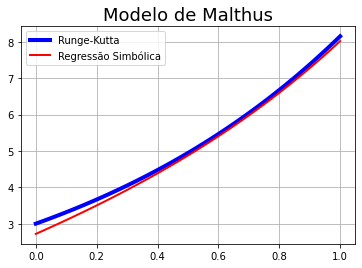

In [12]:
melhor_individuo = str(hof.items[0])
#melhor_individuo_ever = 'X0_mul(Exp(K_mul(t)))'
print(melhor_individuo)
func = toolbox.compile(expr=melhor_individuo)
Xexpr = func(T)
#func = toolbox.compile(expr=melhor_individuo_ever)
#Xbest = func(T)
fig, ax = plt.subplots(1,1)
ax.set_title('Modelo de Malthus', size = 18)
ax.plot(T, X, label = 'Runge-Kutta', c = 'b', linewidth = 4)
ax.plot(T, Xexpr, label = 'Regressão Simbólica', c = 'r', linewidth = 2)
#ax.plot(T, Xbest, label = 'Analitica', c = '0')
ax.legend()

ax.legend()
ax.grid('--')
#plt.savefig('resultados\Resultado_Malthus_1.png', dpi = 200)

### Reportando o melhor individuo encontrado

In [13]:
def Div(left, right):
    return left / right

def Exp(x):
    return sp.exp(x)

new_pset = gp.PrimitiveSet("MAIN", 1)

new_pset.addPrimitive(operator.add, 2)
new_pset.addPrimitive(operator.sub, 2)
new_pset.addPrimitive(operator.mul, 2)
new_pset.addPrimitive(Div, 2)
new_pset.addPrimitive(operator.neg, 1)
new_pset.addPrimitive(sp.cos, 1)
new_pset.addPrimitive(sp.sin, 1)
new_pset.addPrimitive(Exp, 1)


new_pset.addEphemeralConstant("rand102", lambda: rd.randint(-1,1))

new_pset.renameArguments(ARG0='t')
toolbox.register("compile", gp.compile, pset=new_pset)

In [14]:
func = toolbox.compile(expr=melhor_individuo)
t = Symbol('t')
X0 = Symbol('X_0')
K = Symbol('k')

In [15]:
display(sp.expand(func(t)))

E*exp(t) + 1 - exp(-t)